In [20]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from scipy.optimize import curve_fit
data = np.load('data.npy').item()
k_boltz = 8.6173303E-5
plt.rcParams.update({'font.size': 8})
%matplotlib inline

In [21]:
# get the data
wavelength = data['wavelength']
spec_532 = data['532 spectrum']
spec_532_bkg = data['532 bkg']
spec_633 = data['633 spectra']
spec_633_bkg = data['633 bkg']
power_sp = data['633 power']

def lorentziana(xdata, C0, C1, C2, C3):
    return C0/((xdata - C1)**2 + C2) + C3

def temp_fitting(xdata, T0, T1):
    return lorentziana(xdata,P[0], P[1], P[2], P[3])*T0/(np.exp((xdata-1.9586)/(k_boltz*T1))-1)

# Initial guess for the fit (found in the matlab files...)
P = [  3.42368012e+05,   1239.8/6.06514423e+02,   1239.8/9.32145559e+02,    -1.87937746e+01]

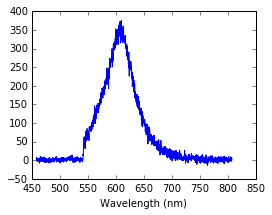

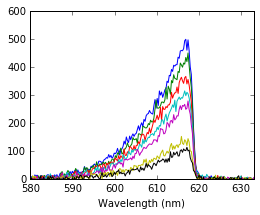

In [22]:
# see the data
f = plt.figure(figsize=(4,3), dpi=600)
plt.plot(wavelength, spec_532-spec_532_bkg)
plt.xlabel('Wavelength (nm)')
plt.show()

f2 = plt.figure(figsize=(4,3), dpi=600)
plt.plot(wavelength, spec_633-spec_633_bkg)
plt.xlabel('Wavelength (nm)')
plt.ylim((0,600))
plt.xlim((580,633))
plt.show()

In [47]:
# export 532nm spectra to a txt file
# TO_SAVE = np.zeros(2,len(wavelength))
# TO_SAVE[1,:]=wavelength
# TO_SAVE[2,:]= spec_532-spec_532_bkg
np.savetxt('aS532nm_spectra.txt',(np.transpose(wavelength),np.transpose(spec_532-spec_532_bkg)))

In [53]:
# export 633nm spectra to a txt file
for n in range(0,len(power_sp)):
    np.savetxt('aS633nm_spectra_pw='+str(power_sp[n])+'.txt',(np.transpose(wavelength),np.transpose(spec_633[:,n]-spec_633_bkg[:,n])))


### get the estimate SPR and width from the max and max/2 values
Here I calculate the SPR simply by taking the center of mass
Then I find the value when the curve goes to half the maxium, looking only to the red side from the max.

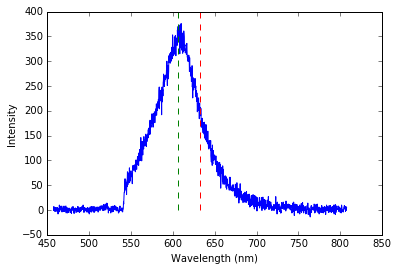

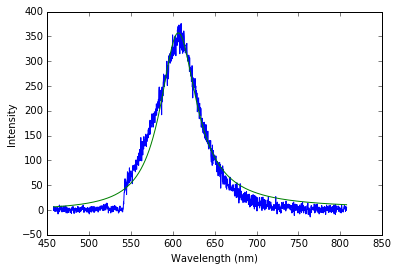

SPR value =  (606.460 +/- 0.263)  nm
SPR Width =  (52.818 +/- 0.526)  nm
SPR value = 2.044 eV
SPR Width = 0.178 eV


In [23]:
# get spr
d = spec_532-spec_532_bkg

ind = np.where(d>np.max(d)*0.8)
x = d[ind]
center_of_mass = (x*np.arange(len(x))).sum()/x.sum()

#f = plt.figure()
#plt.plot(x)
#plt.plot([center_of_mass,center_of_mass],[np.max(d)*0.8,np.max(d)])
ind_max = int(ind[0][0])+int(np.floor(center_of_mass))
SPR = wavelength[ind_max]
eSPR = wavelength[1]-wavelength[0]
signal = np.mean(d[range(int(ind[0][0]+np.floor(center_of_mass)-5),int(ind[0][0]+np.floor(center_of_mass)+5))])
           
# get width
ind_wid = np.argmin(abs(d[wavelength>SPR]-np.max(d[wavelength>SPR])/2))+ind_max
W = 2*(wavelength[ind_wid]-SPR)
eW = 2*eSPR

f = plt.figure()
plt.plot(wavelength, d)
plt.plot([SPR,SPR],[0,400],'--')
plt.plot([SPR+W/2,SPR+W/2],[0,400],'--r')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()


We = 1239.8*W/SPR**2
f = plt.figure()
plt.plot(wavelength, d)
plt.plot(wavelength, lorentziana(1239.8/wavelength, signal*We**2/4, 1239.8/SPR, We**2/4, 0))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()



print('SPR value =  ({0:.3f} +/- {1:.3f})  nm'.format(SPR, eSPR) )
print('SPR Width =  ({0:.3f} +/- {1:.3f})  nm'.format(W, eW) )

SPRe = 1239.8/SPR
print('SPR value = {0:.3f} eV'.format(SPRe) )
print('SPR Width = {0:.3f} eV'.format(We) )

    

SPR width = (0.180  +/- 0.002)eV


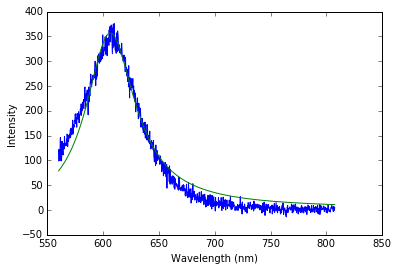

In [24]:
# fit a lorentzian with a fixed center and duplicated data
def lore(xdata, A,WD):
    return A/((xdata - SPRe)**2 + (WD/2)**2) 

r = np.where(wavelength>560)
# lamb = SPR - wavelength[r]
# np.append(lamb,wavelength[r])
# ydat = spec_532[r]-spec_532_bkg[r]
# Y =np.flip(ydat,0)
# np.append(Y,ydat)


# f=plt.figure()
# plt.plot(lamb,Y)
ydata = d[r]
p_ini, pcov_1 = curve_fit(lore, 1239.8/wavelength[r], ydata,[np.max(ydata), We])
ep_ini = np.sqrt(np.diag(pcov_1))


print('SPR width = ({0:.3f}  +/- {1:.3f})eV'.format(p_ini[1],ep_ini[1]) )

f = plt.figure()
plt.plot(wavelength[r], d[r])
plt.plot(wavelength[r], lore(1239.8/wavelength[r], p_ini[0], p_ini[1]))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()




In [25]:
# rr = np.logical_and(wavelength>590, wavelength<614)
# P = [p_ini[0],SPR,p_ini[1],0]
# Tini = np.zeros((2,len(power_sp)))
# eTini = np.zeros((2,len(power_sp)))

# for s_633 in range(len(power_sp)):
#     to_fit = spec_633[:,s_633]-spec_633_bkg[:,s_633]
#     Tini[:,s_633], pcov_ini = curve_fit(temp_fitting, 1239.8/wavelength[rr], to_fit[rr], [1, 300])
#     eTini[:,s_633] = np.sqrt(np.diag(pcov_ini))



In [26]:
# fig = plt.figure(figsize=(6,4), dpi=300)

# for s_633 in range(len(power_sp)):
#     to_fit = spec_633[:,s_633]-spec_633_bkg[:,s_633]
#     plt.plot(wavelength[rr], to_fit[rr],'o')
#     plt.plot(wavelength[rr], temp_fitting(1239.8/wavelength[rr],Tini[0,s_633],Tini[1,s_633]))

# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Intensity')

# plt.show()

In [29]:
# define the wavelengths to cut the curve and fit for each cut value
cut_wl = np.linspace(560,SPR,25)

popt = np.zeros((4, len(cut_wl)))
perr = np.zeros((len(cut_wl),))
j = 0
for i in cut_wl:
    r = wavelength > i
    to_fit = spec_532[r]-spec_532_bkg[r]
    popt[:,j], pcov = curve_fit(lorentziana, 1239.8/wavelength[r], to_fit,[5000, 1.95, 0.3, 0])
    chi_sq = np.sum((lorentziana(1239.8/wavelength[r], popt[0,j], popt[1,j], popt[2,j], popt[3,j])-to_fit)**2)
#     chi_sq = np.sum((lorentziana(1239.8/wavelength[r], popt[0,j], popt[1,j], popt[2,j], popt[3,j])-to_fit)**2/
#                     (lorentziana(1239.8/wavelength[r], popt[0,j], popt[1,j], popt[2,j], popt[3,j])**2))
    perr[j] = chi_sq
    j += 1

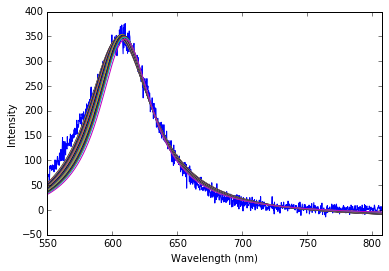

In [30]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.plot(wavelength, spec_532-spec_532_bkg)
for j in range(len(cut_wl)):
        plt.plot(wavelength, lorentziana(1239.8/wavelength, popt[0,j], popt[1,j], popt[2,j], popt[3,j]))

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.xlim((550,np.max(wavelength)))
plt.show()

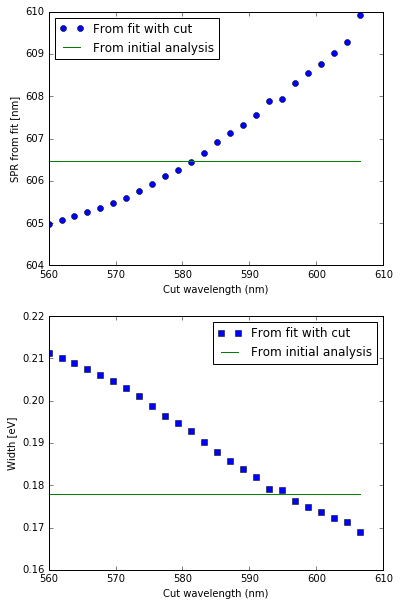

In [31]:
fig = plt.figure(figsize=(6,10), dpi=300)
nrows=2; ncols=1
ax0 = plt.subplot2grid((nrows, ncols), (0,0))
ax1 = plt.subplot2grid((nrows, ncols), (1,0))
#ax10 = plt.subplot2grid((nrows, ncols), (1,0))
#ax11 = plt.subplot2grid((nrows, ncols), (1,1))
ax0.plot(cut_wl,1239.8/popt[1,:],'o',label='From fit with cut')
ax0.plot(cut_wl,SPR*np.ones(len(cut_wl)),label='From initial analysis')
ax0.set_ylabel('SPR from fit [nm]')
ax0.set_xlabel('Cut wavelength (nm)')
ax0.legend(loc=2)

ax1.plot(cut_wl,2*np.sqrt(popt[2,:]),'s',label='From fit with cut')
ax1.plot(cut_wl,We*np.ones(len(cut_wl)),label='From initial analysis')
ax1.set_ylabel('Width [eV]')
ax1.set_xlabel('Cut wavelength (nm)')
ax1.legend(loc=1)

plt.show()

#fig = plt.figure(figsize=(4,3), dpi=300)
#plt.plot(cut_wl,popt[0,:])
#plt.title('Param 0')
#plt.xlabel('Cut wavelength (nm)')
#plt.show()

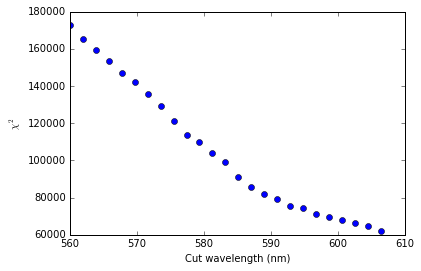

In [32]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.plot(cut_wl, perr,'o')
# plt.plot(cut_wl, len(wavelength)*np.ones(len(cut_wl)))
# plt.ylim((0,1e7))
plt.ylabel(r'$\chi^2$')
plt.xlabel('Cut wavelength (nm)')
plt.show()

In [33]:
# get the temp for each cut_w using the model
T = np.zeros((2,len(power_sp),len(cut_wl)))
eT = np.zeros((2,len(power_sp),len(cut_wl)))

r = np.logical_and(wavelength>590, wavelength<614)
for l_range in range(len(cut_wl)):
    P = popt[:,l_range]
    for s_633 in range(len(power_sp)):
        to_fit = spec_633[:,s_633]-spec_633_bkg[:,s_633]
        T[:,s_633,l_range], pcov = curve_fit(temp_fitting, 1239.8/wavelength[r], to_fit[r], [1, 300])
        eT[:,s_633,l_range] = np.sqrt(np.diag(pcov))
#         T2[:,s_633,l_range], pcov = curve_fit(temp_fitting2, 1239.8/wavelength[r], to_fit[r], 300)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: overflow encountered in exp


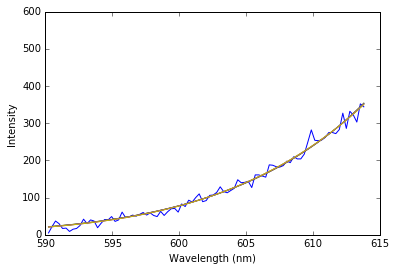

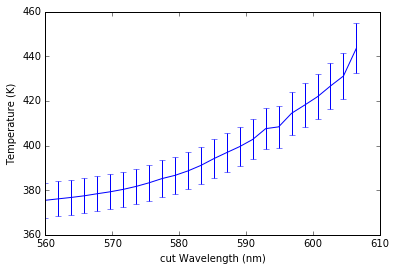

In [38]:
f2 = plt.figure(figsize=(6,4), dpi=600)   
plt.plot(wavelength[r], spec_633[r,1]-spec_633_bkg[r,1])
for l_range in range(0,len(cut_wl),5):
    P = popt[:,l_range] 
    plt.plot(wavelength[r], temp_fitting(1239.8/wavelength[r],T[0,1,l_range],T[1,1,l_range]))

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.ylim((0,600))
# plt.xlim((580,633))
plt.show()

f = plt.figure()
plt.errorbar(cut_wl,T[1,1,:],eT[1,1,:])
plt.xlabel('cut Wavelength (nm)')
plt.ylabel('Temperature (K)')
#plt.ylim((0,600))
#plt.xlim((580,633))
plt.show()


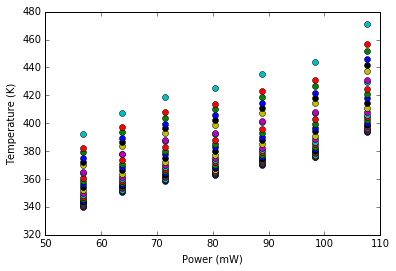

In [54]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.plot(power_sp[:], T[1,:,:],'o')
plt.xlabel('Power (mW)')
plt.ylabel('Temperature (K)')
plt.show()

# fig = plt.figure(figsize=(4,3), dpi=300)
# plt.plot(power_sp[:], T[0,:,:],'o')
# plt.xlabel('Power (mW)')
# plt.ylabel('Temperature (K)')
# plt.show()

<function matplotlib.pyplot.show>

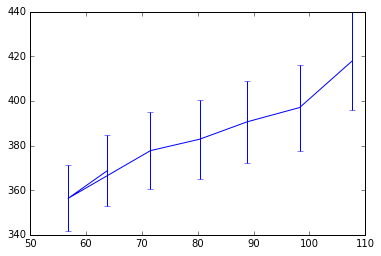

In [63]:
Tmed = np.zeros((len(power_sp)))
eTmed = np.zeros((len(power_sp)))
for l in range(len(power_sp)):
    Tmed[l] = np.mean(T[1,l,:])
    eTmed[l] = np.std(T[1,l,:])

fig = plt.figure()
plt.errorbar(power_sp,Tmed,eTmed)
plt.show

## get room temperature

In [69]:
# get the room temperature
ext_T = np.zeros((len(cut_wl)))
e_ext_T = np.zeros((len(cut_wl)))
for l_range in range(len(cut_wl)):
    POL,cov = np.polyfit(power_sp[:], T[1,:,l_range], 1,cov=True)
    ext_T[l_range] = POL[1]
    e_ext_T[l_range] = np.sqrt(cov[1,1])

    
POL_mean,cov_mean = np.polyfit(power_sp[:], Tmed, 1,cov=True)    
print(POL_mean)

[   1.06311497  298.2956758 ]


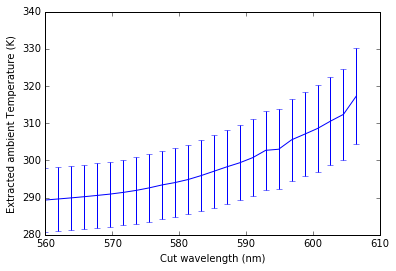

In [41]:
f = plt.figure(figsize=(6,4), dpi=600)
plt.errorbar(cut_wl,ext_T,yerr=e_ext_T)
plt.xlabel('Cut wavelength (nm)')
plt.ylabel('Extracted ambient Temperature (K)')
# plt.ylim((290,310))
# plt.show()
plt.savefig('03_Temp_Vs_Wl.svg')
plt.savefig('03_Temp_Vs_Wl.png')
plt.show()